In [1]:
import numpy as np
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertModel
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_absolute_error
import pandas as pd
import string
from collections import defaultdict, Counter
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
!pip install morfeusz2
import morfeusz2
import nltk
nltk.download('punkt')
nltk.download('wordnet')
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer

# Check for GPU availability and set device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(f'Using device: {device}')

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.6/8.6 MB 13.8 MB/s eta 0:00:00


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Using device: cpu


# Wczytanie danych
Będziemy pracować na zbiorze danych zwierających opinie z allegro. Datasety zawierają opinie wraz z przyporządkowaną liczbą gwiazdek (1-5). Każda opinia zawiera przyjnamniej 50 znaków. Będziemy trenować nasze modele na zestawie treningowym i sprawdzać działanie na zestwie do ewaluacji.
Zacznijmy od wczytania danych i wizualizacji

In [3]:
import pandas as pd

train_df = pd.read_csv('train.tsv', delimiter='\t')
dev_df = pd.read_csv('dev.tsv', delimiter='\t')

# Konwersja ocen na liczby całkowite
train_df['rating'] = train_df['rating'].astype(int)
dev_df['rating'] = dev_df['rating'].astype(int)

print(train_df.head())
print(dev_df.head())

                                                text  rating
0  Jako do ceny dobra. Przyssawka mogłaby być lep...       3
1  Na słuchawkę czekałam spory czas a po zadzwoni...       1
2  Czajnik na pierwszy rzut oka wygląda ok, ale n...       1
3  Bardzo fajny czajnik, na pewno nie gorszy od m...       4
4  Pomysł na produkt (uchwyt na kierownicę) bardz...       2
                                                text  rating
0  Generalnie ok.  Znośna jakość dźwięku. Ale to ...       3
1  W upalne dni przyssawka staje się tak elastycz...       4
2  Według mnie statyw na początku był bardzo fajn...       1
3  Specyfikacja mówi sama za siebie i faktycznie ...       5
4  Wykonanie przeciętne . Krajalnicy nie używamy ...       3


# Wizualizacja danych
Widzimy, że zdecydoawnie największą grupę stanowią opinie z 5 gwiazdkami. Najmniej jest opinii z 2 i 3 gwiazdkami co może stanowić pewien problem, tym bardziej że są to zazwyczaj "trudniejsze" przykłady do klasyfikacji niż opinie na 5 lub 1 gwiazdkę.

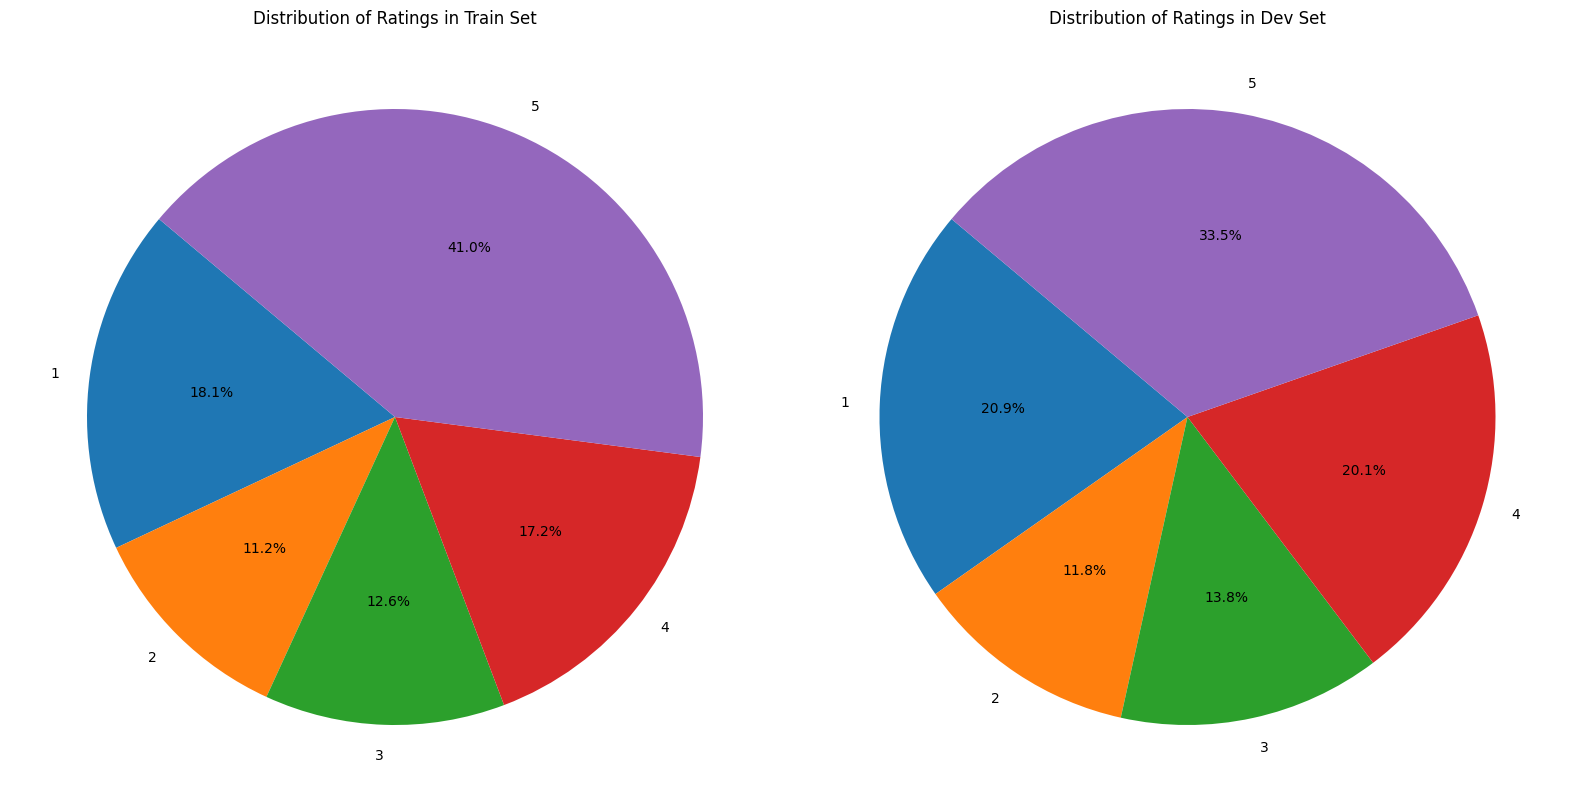

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

# Count the number of entries for each rating
train_rating_counts = train_df['rating'].value_counts().sort_index()
dev_rating_counts = dev_df['rating'].value_counts().sort_index()

# Create a figure and a set of subplots
fig, axs = plt.subplots(1, 2, figsize=(16, 8))

# Plot pie chart for train set
axs[0].pie(train_rating_counts, labels=train_rating_counts.index, autopct='%1.1f%%', startangle=140)
axs[0].set_title('Distribution of Ratings in Train Set')

# Plot pie chart for dev set
axs[1].pie(dev_rating_counts, labels=dev_rating_counts.index, autopct='%1.1f%%', startangle=140)
axs[1].set_title('Distribution of Ratings in Dev Set')

# Display the charts
plt.tight_layout()
plt.show()


# Metryki
Do sprawdzania skuteczności będziemy używać accurancy oraz AR score zaproponowanego przez autorów datasetu. Jest to bardziej sensowna metryka niż zwykłe accurancy, bo uwzględnia jak bardzo się pomylimy.
Przykładowo jeżeli opinię z oceną "5" zakwalifikujemy na "4" to jest to dużo lepiej niż gdybyśmy uznali ją np. za "1"

In [5]:
import pandas as pd
from sklearn.metrics import mean_absolute_error


def ar_score(y_true, y_pred):
    ds = pd.DataFrame({
        'y_true': (y_true - 1.0)/4.0,
        'y_pred': (y_pred - 1.0)/4.0,
    })
    wmae = ds \
        .groupby('y_true') \
        .apply(lambda df: mean_absolute_error(df['y_true'], df['y_pred'])) \
        .mean()

    return 1 - wmae

# 3 różne podejścia do czyszczenia danych
Sprawdzimy jak rózne sposoby przetwarzania tekstu wpłyną na skuteczność przewidywań. W pierwszej wersji stosujemy podstawowe operacje do przetwarzania tekstu, w drugiej dodatkowo usuwamy stopwordy które często pojawiają się w jęxyku polskim, a w trzeciej wersji dodatkowo używamy lemmatizera Morfeusz

In [6]:
# Basic Text Cleaning
def basic_text_cleaning(text):
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = ''.join([i for i in text if not i.isdigit()])
    return text

In [7]:
#  Basic Text Cleaning + Removing Stopwords
def remove_stopwords(text, stopwords_list):
    words = word_tokenize(text)
    words = [word for word in words if word.lower() not in stopwords_list]
    return ' '.join(words)


In [8]:
# Basic Text Cleaning + Removing Stopwords + morfeusz Lemmatization
def lemmatize_text(text, morf):
    words = word_tokenize(text)
    words = [morf.analyse(word)[0][2][1].split(':')[0] for word in words]
    return ' '.join(words)

Sprawdźmy przykłady po przetworzeniu tekstu różnymi metodamu

In [9]:
# Load stopwords
with open('polish.stopwords.txt', 'r') as f:
    stopwords_list = f.read().splitlines()

morf = morfeusz2.Morfeusz()

# Apply data cleaning methods
train_df['text_basic_clean'] = train_df['text'].apply(basic_text_cleaning)
dev_df['text_basic_clean'] = dev_df['text'].apply(basic_text_cleaning)

train_df['text_no_stopwords'] = train_df['text_basic_clean'].apply(lambda x: remove_stopwords(x, stopwords_list))
dev_df['text_no_stopwords'] = dev_df['text_basic_clean'].apply(lambda x: remove_stopwords(x, stopwords_list))

train_df['text_lemmatized'] = train_df['text_no_stopwords'].apply(lambda x: lemmatize_text(x, morf))
dev_df['text_lemmatized'] = dev_df['text_no_stopwords'].apply(lambda x: lemmatize_text(x, morf))

print(train_df.head())
print(dev_df.head())

                                                text  rating  \
0  Jako do ceny dobra. Przyssawka mogłaby być lep...       3   
1  Na słuchawkę czekałam spory czas a po zadzwoni...       1   
2  Czajnik na pierwszy rzut oka wygląda ok, ale n...       1   
3  Bardzo fajny czajnik, na pewno nie gorszy od m...       4   
4  Pomysł na produkt (uchwyt na kierownicę) bardz...       2   

                                    text_basic_clean  \
0  jako do ceny dobra przyssawka mogłaby być leps...   
1  na słuchawkę czekałam spory czas a po zadzwoni...   
2  czajnik na pierwszy rzut oka wygląda ok ale ni...   
3  bardzo fajny czajnik na pewno nie gorszy od ma...   
4  pomysł na produkt uchwyt na kierownicę bardzo ...   

                                   text_no_stopwords  \
0  ceny dobra przyssawka mogłaby lepsza miesiącac...   
1  słuchawkę czekałam spory czas zadzwonieniu oka...   
2  czajnik pierwszy rzut oka wygląda ok polecam w...   
3  fajny czajnik pewno gorszy markowych tefal bos...  

# Naive Bayes Classifier
Pierwszym podejściem jakie zastosujemy będzie NBC.

In [12]:
class NaiveBayesClassifier:
    def __init__(self):
        self.class_priors = {}
        self.word_counts = {}
        self.vocabulary = set()
        self.class_word_counts = {}

    def fit(self, texts, labels):
        total_count = len(labels)
        label_counts = Counter(labels)

        # Calculate class priors
        for label, count in label_counts.items():
            self.class_priors[label] = count / total_count
            self.word_counts[label] = defaultdict(int)
            self.class_word_counts[label] = 0

        # Count words per class
        for text, label in zip(texts, labels):
            words = text.split()
            for word in words:
                self.vocabulary.add(word)
                self.word_counts[label][word] += 1
                self.class_word_counts[label] += 1

    def predict(self, texts):
        predictions = []
        for text in texts:
            words = text.split()
            class_scores = {}
            for label in self.class_priors.keys():
                # Initialize with the class prior
                class_scores[label] = self.class_priors[label]
                # Multiply by the likelihood of each word in the text
                for word in words:
                    word_count = self.word_counts[label].get(word, 0) + 1  # Add-one smoothing
                    total_words = self.class_word_counts[label] + len(self.vocabulary)
                    class_scores[label] *= word_count / total_words
            predictions.append(max(class_scores, key=class_scores.get))
        return predictions

# Train and test the classifier using different cleaning methods
def train_and_evaluate(train_texts, train_labels, dev_texts, dev_labels):
    classifier = NaiveBayesClassifier()
    classifier.fit(train_texts, train_labels)
    predictions = classifier.predict(dev_texts)
    accuracy = (predictions == dev_labels).mean()
    arscore = ar_score(np.array(dev_labels), np.array(predictions))
    return accuracy, arscore

# Evaluate different cleaning methods
results = {}

# Raw Text
accuracy, arscore = train_and_evaluate(train_df['text'], train_df['rating'], dev_df['text'], dev_df['rating'])
results['Raw Text'] = (accuracy, arscore)
print(f"Raw Text accurancy: {accuracy}")
print(f"Raw Text arscore: {arscore}")
print(f"==============================================================")

# Basic Cleaning
accuracy, arscore = train_and_evaluate(train_df['text_basic_clean'], train_df['rating'], dev_df['text_basic_clean'], dev_df['rating'])
results['Basic Cleaning'] = (accuracy, arscore)
print(f"Basic Cleaning accurancy: {accuracy}")
print(f"Basic Cleaning arscore: {arscore}")
print(f"==============================================================")

# No Stopwords
accuracy, arscore = train_and_evaluate(train_df['text_no_stopwords'], train_df['rating'], dev_df['text_no_stopwords'], dev_df['rating'])
results['No Stopwords'] = (accuracy, arscore)
print(f"No Stopwords accurancy: {accuracy}")
print(f"No Stopwords arscore: {arscore}")
print(f"==============================================================")

# Lemmatization
accuracy, arscore = train_and_evaluate(train_df['text_lemmatized'], train_df['rating'], dev_df['text_lemmatized'], dev_df['rating'])
results['Lemmatization'] = (accuracy, arscore)
print(f"Lemmatization accurancy: {accuracy}")
print(f"Lemmatization arscore: {arscore}")
print(f"==============================================================")


Raw Text accurancy: 0.41916167664670656
Raw Text arscore: 0.6995178047679269
Basic Cleaning accurancy: 0.469061876247505
Basic Cleaning arscore: 0.7381670705145645
No Stopwords accurancy: 0.48902195608782434
No Stopwords arscore: 0.7405557517914758
Lemmatization accurancy: 0.469061876247505
Lemmatization arscore: 0.7207749398235391


# Wizualizacja wyników


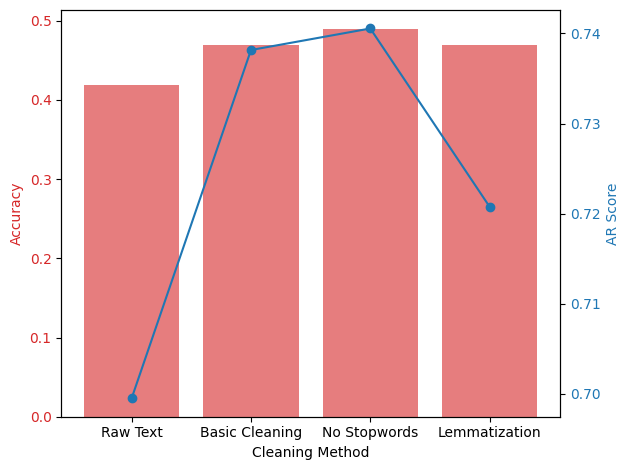

In [13]:
import matplotlib.pyplot as plt

methods = list(results.keys())
accuracies = [results[method][0] for method in methods]
arscores = [results[method][1] for method in methods]

x = range(len(methods))

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Cleaning Method')
ax1.set_ylabel('Accuracy', color=color)
ax1.bar(x, accuracies, color=color, alpha=0.6, label='Accuracy')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(x)
ax1.set_xticklabels(methods)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('AR Score', color=color)  # we already handled the x-label with ax1
ax2.plot(x, arscores, color=color, marker='o', label='AR Score')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


# Inne podejście - prosta sieć neuronowa

In [14]:
# Define a simple CNN for text classification
class SimpleNN(nn.Module):
    def __init__(self, num_features):
        super(SimpleNN, self).__init__()
        self.fc1 = nn.Linear(num_features, 16)
        self.fc2 = nn.Linear(16, 32)
        self.fc3 = nn.Linear(32, 16)
        self.fc4 = nn.Linear(16, 5)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = self.fc4(x)
        return x

# Tworzenie datasetów w formie dostosowanej do NN

In [15]:
# Custom dataset class
class TextDataset(Dataset):
    def __init__(self, texts, labels):
        self.texts = texts
        self.labels = labels

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        return self.texts[idx], self.labels[idx]

# Simple tokenizer function
def simple_tokenizer(text):
    return word_tokenize(text.lower())

# Function to create data loaders
def create_data_loaders(train_texts, train_labels, dev_texts, dev_labels, vectorizer):
    X_train = vectorizer.fit_transform(train_texts).toarray()
    X_dev = vectorizer.transform(dev_texts).toarray()

    # Convert texts to tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_dev = torch.tensor(X_dev, dtype=torch.float32)

    # Encode labels
    label_encoder = LabelEncoder()
    y_train = torch.tensor(label_encoder.fit_transform(train_labels), dtype=torch.long)
    y_dev = torch.tensor(label_encoder.transform(dev_labels), dtype=torch.long)

    # Create datasets and data loaders
    train_dataset = TextDataset(X_train, y_train)
    dev_dataset = TextDataset(X_dev, y_dev)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    dev_loader = DataLoader(dev_dataset, batch_size=32, shuffle=False)

    return train_loader, dev_loader, X_train.shape[1]

# Pętla treningowa

In [16]:
# Function to train and evaluate the model
def train_and_evaluate(train_loader, dev_loader, input_size, num_epochs=10):
    model = SimpleNN(num_features=input_size).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        for texts, labels in train_loader:
            texts, labels = texts.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(texts)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        predictions = []
        for texts, labels in dev_loader:
            texts, labels = texts.to(device), labels.to(device)
            outputs = model(texts)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            predictions.extend(predicted.cpu().numpy() + 1) #back to label 1-5

    accuracy = 100 * correct / total
    return accuracy, predictions


# Wyniki
Widzimy, że generalnie wyniki sieci neuronowej są bardzo zbliżone niezależnie od wybranej metody przetwarzania tekstu. Niemniej jednak są one wyraźnie wyższe niż w przybadku NBC zarówno pod względem accuracy jak i ar_score

In [19]:
# Vectorizers
vectorizer_raw = CountVectorizer(tokenizer=simple_tokenizer)
vectorizer_basic = CountVectorizer(tokenizer=simple_tokenizer)
vectorizer_stopwords = CountVectorizer(tokenizer=simple_tokenizer)
vectorizer_lemmatized = CountVectorizer(tokenizer=simple_tokenizer)

# Training and evaluation
results = {}

# Raw Text
train_loader, dev_loader, input_size = create_data_loaders(train_df['text'], train_df['rating'], dev_df['text'], dev_df['rating'], vectorizer_basic)
accuracy, predictions = train_and_evaluate(train_loader, dev_loader, input_size)
arscore = ar_score(np.array(dev_df['rating']), np.array(predictions))
results['Raw Text'] = (accuracy, arscore)

print(f"Raw Text accurancy: {accuracy}")
print(f"Raw Text arscore: {arscore}")
print(f"==============================================================")

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Epoch 1/10, Loss: 0.8915970921516418
Epoch 2/10, Loss: 0.9670464992523193
Epoch 3/10, Loss: 0.8799364566802979
Epoch 4/10, Loss: 0.10556694120168686
Epoch 5/10, Loss: 0.006062192376703024
Epoch 6/10, Loss: 0.0148850679397583
Epoch 7/10, Loss: 0.01691104844212532
Epoch 8/10, Loss: 0.05557815358042717
Epoch 9/10, Loss: 0.004353719297796488
Epoch 10/10, Loss: 0.0027437517419457436
Raw Text accurancy: 51.19760479041916
Raw Text arscore: 0.8233997451827876


In [20]:
# Basic Cleaning
train_loader, dev_loader, input_size = create_data_loaders(train_df['text_basic_clean'], train_df['rating'], dev_df['text_basic_clean'], dev_df['rating'], vectorizer_basic)
accuracy, predictions = train_and_evaluate(train_loader, dev_loader, input_size)
arscore = ar_score(np.array(dev_df['rating']), np.array(predictions))
results['Basic Cleaning'] = (accuracy, arscore)

print(f"Basic Cleaning accurancy: {accuracy}")
print(f"Basic Cleaning arscore: {arscore}")
print(f"==============================================================")

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Epoch 1/10, Loss: 0.591691792011261
Epoch 2/10, Loss: 0.39944422245025635
Epoch 3/10, Loss: 0.2119176983833313
Epoch 4/10, Loss: 0.015215251594781876
Epoch 5/10, Loss: 0.022284843027591705
Epoch 6/10, Loss: 0.04793720319867134
Epoch 7/10, Loss: 0.0011230772361159325
Epoch 8/10, Loss: 0.0233723483979702
Epoch 9/10, Loss: 0.017595814540982246
Epoch 10/10, Loss: 0.0005095290252938867
Basic Cleaning accurancy: 52.19560878243513
Basic Cleaning arscore: 0.8103094682557421


In [21]:
# No Stopwords
train_loader, dev_loader, input_size = create_data_loaders(train_df['text_no_stopwords'], train_df['rating'], dev_df['text_no_stopwords'], dev_df['rating'], vectorizer_stopwords)
accuracy, predictions = train_and_evaluate(train_loader, dev_loader, input_size)
arscore = ar_score(np.array(dev_df['rating']), np.array(predictions))
results['No Stopwords'] = (accuracy, arscore)

print(f"No Stopwords accurancy: {accuracy}")
print(f"No Stopwords arscore: {arscore}")
print(f"==============================================================")

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Epoch 1/10, Loss: 0.8231000900268555
Epoch 2/10, Loss: 0.9736964106559753
Epoch 3/10, Loss: 0.5099686980247498
Epoch 4/10, Loss: 0.4449259340763092
Epoch 5/10, Loss: 0.024825159460306168
Epoch 6/10, Loss: 0.0036814974155277014
Epoch 7/10, Loss: 0.010876213200390339
Epoch 8/10, Loss: 0.010676683858036995
Epoch 9/10, Loss: 0.026672188192605972
Epoch 10/10, Loss: 0.014201221987605095
No Stopwords accurancy: 52.29540918163673
No Stopwords arscore: 0.8182887711072826


In [22]:
# Lemmatization
train_loader, dev_loader, input_size = create_data_loaders(train_df['text_lemmatized'], train_df['rating'], dev_df['text_lemmatized'], dev_df['rating'], vectorizer_lemmatized)
accuracy, predictions = train_and_evaluate(train_loader, dev_loader, input_size)
arscore = ar_score(np.array(dev_df['rating']), np.array(predictions))
results['Lemmatization'] = (accuracy, arscore)

print(f"Lemmatization accurancy: {accuracy}")
print(f"Lemmatization arscore: {arscore}")
print(f"==============================================================")

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Epoch 1/10, Loss: 0.7449591159820557
Epoch 2/10, Loss: 1.0144307613372803
Epoch 3/10, Loss: 0.5803349018096924
Epoch 4/10, Loss: 0.323323130607605
Epoch 5/10, Loss: 0.0862489715218544
Epoch 6/10, Loss: 0.46765750646591187
Epoch 7/10, Loss: 0.01359308697283268
Epoch 8/10, Loss: 0.07358996570110321
Epoch 9/10, Loss: 0.3231377601623535
Epoch 10/10, Loss: 0.05337880551815033
Lemmatization accurancy: 49.40119760479042
Lemmatization arscore: 0.7964941885870781


# Wizualizacja wyników

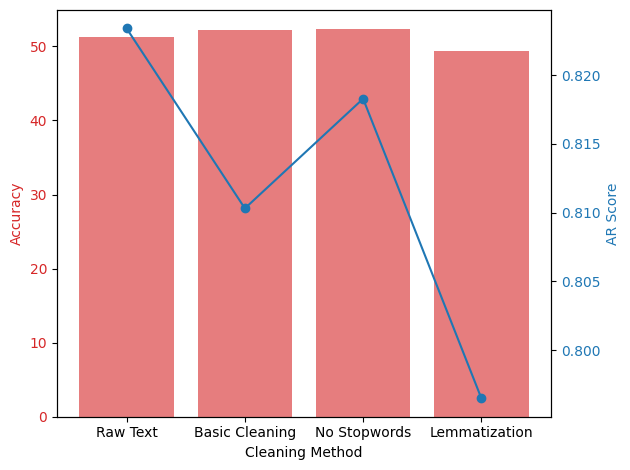

In [23]:
# Plot the results
import matplotlib.pyplot as plt

methods = list(results.keys())
accuracies = [results[method][0] for method in methods]
arscores = [results[method][1] for method in methods]

x = range(len(methods))

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Cleaning Method')
ax1.set_ylabel('Accuracy', color=color)
ax1.bar(x, accuracies, color=color, alpha=0.6, label='Accuracy')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(x)
ax1.set_xticklabels(methods)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('AR Score', color=color)  # we already handled the x-label with ax1
ax2.plot(x, arscores, color=color, marker='o', label='AR Score')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


# Inne podejścia - regresja liniowa i SVM
Sprawdźmy także jak radzą sobie inne klasyczne meodele wykorzystywane do klasyfikacji - regresja liniowa oraz SVM

**1) Regresja liniowa**

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

vectorizer = CountVectorizer(tokenizer=simple_tokenizer)

# Evaluate different cleaning methods
results = {}

# Raw Text
X_train = vectorizer.fit_transform(train_df['text'])
X_dev = vectorizer.transform(dev_df['text'])
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, train_df['rating'])
y_pred = logreg.predict(X_dev)
accuracy = accuracy_score(dev_df['rating'], y_pred)
arscore = ar_score(np.array(dev_df['rating']), np.array(y_pred))
results['Raw Text'] = (accuracy, arscore)
print(f"Raw Text accurancy: {accuracy}")
print(f"Raw Text arscore: {arscore}")
print(f"==============================================================")

# Basic Cleaning
X_train = vectorizer.fit_transform(train_df['text_basic_clean'])
X_dev = vectorizer.transform(dev_df['text_basic_clean'])
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, train_df['rating'])
y_pred = logreg.predict(X_dev)
accuracy = accuracy_score(dev_df['rating'], y_pred)
arscore = ar_score(np.array(dev_df['rating']), np.array(y_pred))
results['Basic Cleaning'] = (accuracy, arscore)
print(f"Basic Cleaning accurancy: {accuracy}")
print(f"Basic Cleaning arscore: {arscore}")
print(f"==============================================================")

# No Stopwords
X_train = vectorizer.fit_transform(train_df['text_no_stopwords'])
X_dev = vectorizer.transform(dev_df['text_no_stopwords'])
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, train_df['rating'])
y_pred = logreg.predict(X_dev)
accuracy = accuracy_score(dev_df['rating'], y_pred)
arscore = ar_score(np.array(dev_df['rating']), np.array(y_pred))
results['No Stopwords'] = (accuracy, arscore)
print(f"No Stopwords accurancy: {accuracy}")
print(f"No Stopwords arscore: {arscore}")
print(f"==============================================================")

# Lemmatization
X_train = vectorizer.fit_transform(train_df['text_lemmatized'])
X_dev = vectorizer.transform(dev_df['text_lemmatized'])
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_train, train_df['rating'])
y_pred = logreg.predict(X_dev)
accuracy = accuracy_score(dev_df['rating'], y_pred)
arscore = ar_score(np.array(dev_df['rating']), np.array(y_pred))
results['Lemmatization'] = (accuracy, arscore)
print(f"Lemmatization accurancy: {accuracy}")
print(f"Lemmatization arscore: {arscore}")
print(f"==============================================================")


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Raw Text accurancy: 0.5419161676646707
Raw Text arscore: 0.7956678942233392


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Basic Cleaning accurancy: 0.5299401197604791
Basic Cleaning arscore: 0.7864716812988312


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


No Stopwords accurancy: 0.5169660678642715
No Stopwords arscore: 0.7749986825057623


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Lemmatization accurancy: 0.5059880239520959
Lemmatization arscore: 0.7771992884417203


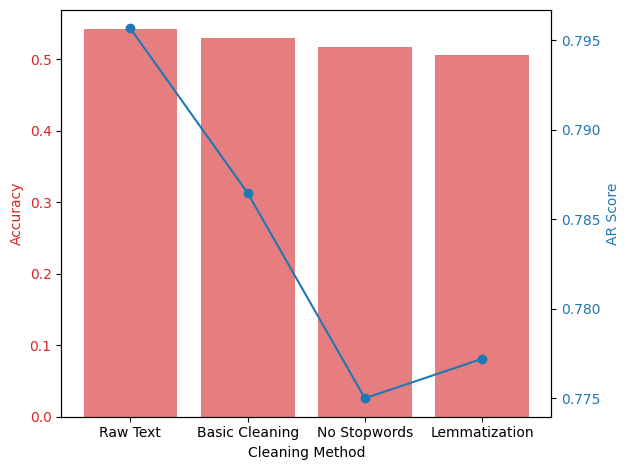

In [26]:
# Plot the results
import matplotlib.pyplot as plt

methods = list(results.keys())
accuracies = [results[method][0] for method in methods]
arscores = [results[method][1] for method in methods]

x = range(len(methods))

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Cleaning Method')
ax1.set_ylabel('Accuracy', color=color)
ax1.bar(x, accuracies, color=color, alpha=0.6, label='Accuracy')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(x)
ax1.set_xticklabels(methods)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('AR Score', color=color)  # we already handled the x-label with ax1
ax2.plot(x, arscores, color=color, marker='o', label='AR Score')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


In [48]:
from sklearn.svm import LinearSVC

# Evaluate different cleaning methods
results = {}

# Raw Text
X_train = vectorizer.fit_transform(train_df['text'])
X_dev = vectorizer.transform(dev_df['text'])
svm_model = LinearSVC(max_iter=1000)
svm_model.fit(X_train, train_df['rating'])
y_pred = svm_model.predict(X_dev)
accuracy = accuracy_score(dev_df['rating'], y_pred)
arscore = ar_score(np.array(dev_df['rating']), np.array(y_pred))
results['Raw Text'] = (accuracy, arscore)
print(f"Raw Text accurancy: {accuracy}")
print(f"Raw Text arscore: {arscore}")
print(f"==============================================================")

# Basic Cleaning
X_train = vectorizer.fit_transform(train_df['text_basic_clean'])
X_dev = vectorizer.transform(dev_df['text_basic_clean'])
svm_model = LinearSVC(max_iter=1000)
svm_model.fit(X_train, train_df['rating'])
y_pred = svm_model.predict(X_dev)
accuracy = accuracy_score(dev_df['rating'], y_pred)
arscore = ar_score(np.array(dev_df['rating']), np.array(y_pred))
results['Basic Cleaning'] = (accuracy, arscore)
print(f"Basic Cleaning accurancy: {accuracy}")
print(f"Basic Cleaning arscore: {arscore}")
print(f"==============================================================")

# No Stopwords
X_train = vectorizer.fit_transform(train_df['text_no_stopwords'])
X_dev = vectorizer.transform(dev_df['text_no_stopwords'])
svm_model = LinearSVC(max_iter=1000)
svm_model.fit(X_train, train_df['rating'])
y_pred = svm_model.predict(X_dev)
accuracy = accuracy_score(dev_df['rating'], y_pred)
arscore = ar_score(np.array(dev_df['rating']), np.array(y_pred))
results['No Stopwords'] = (accuracy, arscore)
print(f"No Stopwords accurancy: {accuracy}")
print(f"No Stopwords arscore: {arscore}")
print(f"==============================================================")

# Lemmatization
X_train = vectorizer.fit_transform(train_df['text_lemmatized'])
X_dev = vectorizer.transform(dev_df['text_lemmatized'])
svm_model = LinearSVC(max_iter=1000)
svm_model.fit(X_train, train_df['rating'])
y_pred = svm_model.predict(X_dev)
accuracy = accuracy_score(dev_df['rating'], y_pred)
arscore = ar_score(np.array(dev_df['rating']), np.array(y_pred))
results['Lemmatization'] = (accuracy, arscore)
print(f"Lemmatization accurancy: {accuracy}")
print(f"Lemmatization arscore: {arscore}")
print(f"==============================================================")

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Raw Text accurancy: 0.5249500998003992
Raw Text arscore: 0.7891222850756887


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Basic Cleaning accurancy: 0.5079840319361277
Basic Cleaning arscore: 0.7773587199358678


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


No Stopwords accurancy: 0.5039920159680639
No Stopwords arscore: 0.767604606779252
Lemmatization accurancy: 0.46107784431137727
Lemmatization arscore: 0.7531007053188596


/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


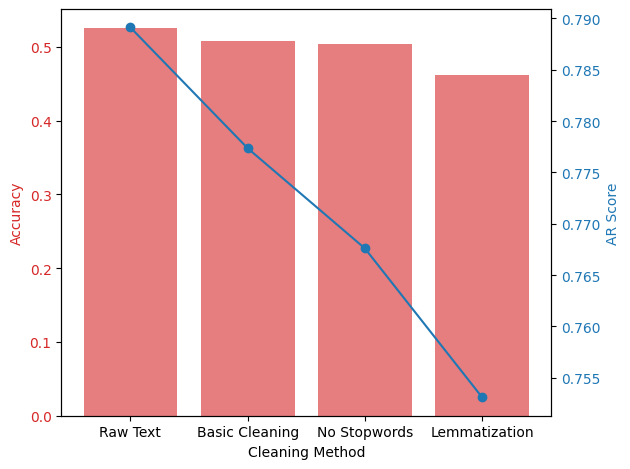

In [50]:
# Plot the results
import matplotlib.pyplot as plt

methods = list(results.keys())
accuracies = [results[method][0] for method in methods]
arscores = [results[method][1] for method in methods]

x = range(len(methods))

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Cleaning Method')
ax1.set_ylabel('Accuracy', color=color)
ax1.bar(x, accuracies, color=color, alpha=0.6, label='Accuracy')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(x)
ax1.set_xticklabels(methods)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('AR Score', color=color)  # we already handled the x-label with ax1
ax2.plot(x, arscores, color=color, marker='o', label='AR Score')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


Widzimy, że zarówno regresja liniowa jak i SVM radzą sobie lepiej niż NBC, ale jednocześnie ar_score jest nieco niższe niż dla prostej siexi neuronowej.

# Modyfikacja sieci neuronowej - uwzględnienie dodatkowych informacji
Zarówno w negatywnych jak i pozytywnych opiniach często używane są emocjonalne słowa, aby podkreślić swoje zdanie. Użycie np. słowa "głupi" albo "beznadziejny" dosyć jednoznacznie wskazuje na negatywny wydźwięk opinii, podczas gdy słowa takie jak "świetny", "piękny" wskazują na pozytywne emocje.

Spróbujemy zatem zmodyfikować naszą wcześniejszą sieć nauronową tak aby mocniej uwzględnić takie słowa o jednoznacznym wydźwięku. Do tego celu użyjemy dwóch zestawów słów: pozytywnych oraz negatywnych. Oba zestawy liczą ok. 500 słów.

1) Podstawowa sieć działa dokładnie tak samo jak wcześniej

2) Dodatkowo dla każdej opinii zliczymy ile razy występują w niej słowa negatywne i pozytywne i obliczone na tej podstawie wartości przekażemy do osobnych sieci neuronowych

3) W ostatniej warstwie łączymy reprezentacje cech pozytywnych i negatywnych razem z reprezentacją cech przetworzonego tekstu i na tej podstawie dokonujemy klasyfikacji

Dzięki zastosowaniu takiego mechanizmu nasza sieć dalej ma informacje bezpośrednio na podstawie tekstu, ale dodatkowo otrzymuje informacje, które powinny pomóc nakierować się we właściwą stronę w przypadku wystąpienia słów o jednoznacznym charakterze pozytywnym allbo negatywnym

In [37]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from nltk.tokenize import word_tokenize
import numpy as np


def calculate_sentiment_scores(text, negative_words, positive_words):
    tokens = simple_tokenizer(text)
    # "lemma" is the word without the 2 last chars
    negative_score = sum(1 for word in tokens if any(word[:-2] in neg_word for neg_word in negative_words)) + 1
    positive_score = sum(1 for word in tokens if any(word[:-2] in pos_word for pos_word in positive_words)) + 1
    total_words = len(tokens) + 1

    return negative_score / total_words, positive_score / total_words

class TextDataset(Dataset):
    def __init__(self, vectorized_texts, labels, original_texts, negative_words, positive_words):
        self.vectorized_texts = vectorized_texts
        self.labels = labels
        self.original_texts = original_texts
        self.negative_words = negative_words
        self.positive_words = positive_words

    def __len__(self):
        return len(self.vectorized_texts)

    def __getitem__(self, idx):
        vectorized_text = self.vectorized_texts[idx]
        label = self.labels[idx]
        # Calculate sentiment scores from the original text
        negative_score, positive_score = calculate_sentiment_scores(self.original_texts[idx], self.negative_words, self.positive_words)
        return vectorized_text, label, negative_score, positive_score

class SimpleNN(nn.Module):
    def __init__(self, num_features):
        super(SimpleNN, self).__init__()
        # Main text features pathway
        self.fc1 = nn.Linear(num_features, 16)
        self.fc2 = nn.Linear(16, 32)
        self.fc3 = nn.Linear(32, 16)

        # Separate pathways for negative and positive sentiment scores
        self.negative_fc1 = nn.Linear(1, 8)
        self.negative_fc2 = nn.Linear(8, 16)
        self.positive_fc1 = nn.Linear(1, 8)
        self.positive_fc2 = nn.Linear(8, 16)

        # Final layer
        self.fc4 = nn.Linear(16 + 16 + 16, 5)  # Combining text features with negative and positive sentiment pathways

    def forward(self, x, negative_score, positive_score):
        # Main text features pathway
        negative_score = negative_score.float()
        positive_score = positive_score.float()
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))

        # Negative sentiment pathway
        negative_score = torch.relu(self.negative_fc1(negative_score.unsqueeze(1)))
        negative_score = torch.relu(self.negative_fc2(negative_score))

        # Positive sentiment pathway
        positive_score = torch.relu(self.positive_fc1(positive_score.unsqueeze(1)))
        positive_score = torch.relu(self.positive_fc2(positive_score))

        # Combine the outputs from all pathways
        x = torch.cat((x, negative_score, positive_score), dim=1)
        return x


# Modify your create_data_loaders function to include the original texts
def create_data_loaders(train_texts, train_labels, dev_texts, dev_labels, vectorizer, negative_words, positive_words):
    X_train = vectorizer.fit_transform(train_texts).toarray()
    X_dev = vectorizer.transform(dev_texts).toarray()

    # Convert vectorized texts to tensors
    X_train = torch.tensor(X_train, dtype=torch.float32)
    X_dev = torch.tensor(X_dev, dtype=torch.float32)

    # Encode labels
    label_encoder = LabelEncoder()
    y_train = torch.tensor(label_encoder.fit_transform(train_labels), dtype=torch.long)
    y_dev = torch.tensor(label_encoder.transform(dev_labels), dtype=torch.long)

    # Create datasets and data loaders
    train_dataset = TextDataset(X_train, y_train, train_texts, negative_words, positive_words)
    dev_dataset = TextDataset(X_dev, y_dev, dev_texts, negative_words, positive_words)

    train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    dev_loader = DataLoader(dev_dataset, batch_size=32, shuffle=False)

    return train_loader, dev_loader, X_train.shape[1]

# Modify the training loop to use vectorized_text for the model input
def train_and_evaluate(train_loader, dev_loader, input_size, num_epochs=10):
    model = SimpleNN(num_features=input_size).to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        for vectorized_text, labels, negative_score, positive_score in train_loader:
            vectorized_text, labels = vectorized_text.to(device), labels.to(device)
            negative_score, positive_score = negative_score.to(device), positive_score.to(device)
            optimizer.zero_grad()
            outputs = model(vectorized_text, negative_score, positive_score)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}")

    # Evaluate the model
    model.eval()
    with torch.no_grad():
        correct = 0
        total = 0
        predictions = []
        for vectorized_text, labels, negative_score, positive_score in dev_loader:
            vectorized_text, labels = vectorized_text.to(device), labels.to(device)
            negative_score, positive_score = negative_score.to(device), positive_score.to(device)
            outputs = model(vectorized_text, negative_score, positive_score)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            predictions.extend(predicted.cpu().numpy() + 1) #back to label 1-5

    accuracy = 100 * correct / total
    return accuracy, predictions


In [30]:
# Function to read words from a file into a list
def load_words_from_file(file_path):
    with open(file_path, 'r') as file:
        words = file.read().splitlines()
    return words

# Load negative and positive words from txt files
negative_words = load_words_from_file('niefajneslowa.txt')  # Replace with your actual file path
positive_words = load_words_from_file('fajneslowa.txt')  # Replace with your actual file path

# Vectorizers
vectorizer_raw = CountVectorizer(tokenizer=simple_tokenizer)

# Training and evaluation
results = {}

# Raw Text
# Pass the negative and positive words lists to the create_data_loaders function
train_loader, dev_loader, input_size = create_data_loaders(
    train_df['text'],
    train_df['rating'],
    dev_df['text'],
    dev_df['rating'],
    vectorizer_raw,
    negative_words,
    positive_words
)

# Train and evaluate the model with the new data loaders that include sentiment scores
accuracy, predictions = train_and_evaluate(train_loader, dev_loader, input_size)

# Calculate the adjusted rand score (assuming ar_score function is defined)
arscore = ar_score(np.array(dev_df['rating']), np.array(predictions))

# Store the results
results['Raw Text'] = (accuracy, arscore)


/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Epoch 1/10, Loss: 1.6413995027542114
Epoch 2/10, Loss: 0.5756399631500244
Epoch 3/10, Loss: 0.5180143713951111
Epoch 4/10, Loss: 0.1373067945241928
Epoch 5/10, Loss: 0.03975498676300049
Epoch 6/10, Loss: 0.017928829416632652
Epoch 7/10, Loss: 0.006960743106901646
Epoch 8/10, Loss: 0.003323993878439069
Epoch 9/10, Loss: 0.002631229115650058
Epoch 10/10, Loss: 0.0023133973591029644


Widzimy że o ile ar_score jest bardzo zbliżony do wcześniejszej wersji, to accuracy wyraźnie wzrosło i znacznie przekroczyło 50% co należy uznać za pewne usprawnienie naszej wcześniejszej wersji

In [31]:
print(accuracy)
print(arscore)

55.489021956087825
0.8103008656924816


In [32]:
# Basic Cleaning
# Pass the negative and positive words lists to the create_data_loaders function
train_loader, dev_loader, input_size = create_data_loaders(
    train_df['text_basic_clean'],
    train_df['rating'],
    dev_df['text_basic_clean'],
    dev_df['rating'],
    vectorizer_raw,
    negative_words,
    positive_words
)

# Train and evaluate the model with the new data loaders that include sentiment scores
accuracy, predictions = train_and_evaluate(train_loader, dev_loader, input_size)

# Calculate the adjusted rand score (assuming ar_score function is defined)
arscore = ar_score(np.array(dev_df['rating']), np.array(predictions))

# Store the results
results['Basic Cleaning'] = (accuracy, arscore)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Epoch 1/10, Loss: 2.1770784854888916
Epoch 2/10, Loss: 1.1424555778503418
Epoch 3/10, Loss: 1.2146977186203003
Epoch 4/10, Loss: 0.9960953593254089
Epoch 5/10, Loss: 1.2960569858551025
Epoch 6/10, Loss: 0.4341696500778198
Epoch 7/10, Loss: 0.43203970789909363
Epoch 8/10, Loss: 0.8624065518379211
Epoch 9/10, Loss: 0.04467712342739105
Epoch 10/10, Loss: 0.4330202341079712


In [33]:
print(accuracy)
print(arscore)

55.28942115768463
0.7909224804349083


In [40]:
# No Stopwords
# Pass the negative and positive words lists to the create_data_loaders function
train_loader, dev_loader, input_size = create_data_loaders(
    train_df['text_no_stopwords'],
    train_df['rating'],
    dev_df['text_no_stopwords'],
    dev_df['rating'],
    vectorizer_raw,
    negative_words,
    positive_words
)

# Train and evaluate the model with the new data loaders that include sentiment scores
accuracy, predictions = train_and_evaluate(train_loader, dev_loader, input_size)

# Calculate the adjusted rand score (assuming ar_score function is defined)
arscore = ar_score(np.array(dev_df['rating']), np.array(predictions))

# Store the results
results['No Stopwords'] = (accuracy, arscore)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Epoch 1/10, Loss: 1.392088532447815
Epoch 2/10, Loss: 1.1815227270126343
Epoch 3/10, Loss: 0.33635544776916504
Epoch 4/10, Loss: 0.0630883052945137
Epoch 5/10, Loss: 0.029373712837696075
Epoch 6/10, Loss: 0.008487213402986526
Epoch 7/10, Loss: 0.014667068608105183
Epoch 8/10, Loss: 0.0032588026951998472
Epoch 9/10, Loss: 0.010088435374200344
Epoch 10/10, Loss: 0.0024919393472373486


In [41]:
print(accuracy)
print(arscore)

52.79441117764471
0.7933384155863853


In [44]:
# Lemmatization
# Pass the negative and positive words lists to the create_data_loaders function
train_loader, dev_loader, input_size = create_data_loaders(
    train_df['text_lemmatized'],
    train_df['rating'],
    dev_df['text_lemmatized'],
    dev_df['rating'],
    vectorizer_raw,
    negative_words,
    positive_words
)

# Train and evaluate the model with the new data loaders that include sentiment scores
accuracy, predictions = train_and_evaluate(train_loader, dev_loader, input_size)

# Calculate the adjusted rand score (assuming ar_score function is defined)
arscore = ar_score(np.array(dev_df['rating']), np.array(predictions))

# Store the results
results['Lemmatization'] = (accuracy, arscore)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Epoch 1/10, Loss: 2.0516672134399414
Epoch 2/10, Loss: 0.9121776223182678
Epoch 3/10, Loss: 0.7484240531921387
Epoch 4/10, Loss: 0.7905657887458801
Epoch 5/10, Loss: 0.11954609304666519
Epoch 6/10, Loss: 0.011577526107430458
Epoch 7/10, Loss: 0.03483658656477928
Epoch 8/10, Loss: 0.01828884333372116
Epoch 9/10, Loss: 0.018994083628058434
Epoch 10/10, Loss: 0.0064390371553599834


In [45]:
print(accuracy)
print(arscore)

50.199600798403196
0.7812459914770292


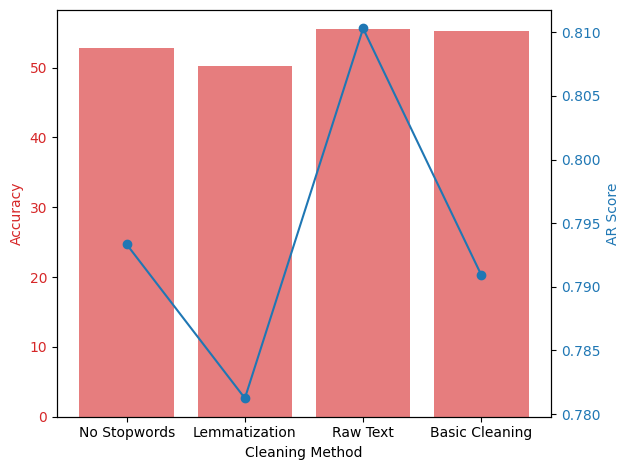

In [47]:
# Plot the results
import matplotlib.pyplot as plt

methods = list(results.keys())
accuracies = [results[method][0] for method in methods]
arscores = [results[method][1] for method in methods]

x = range(len(methods))

fig, ax1 = plt.subplots()

color = 'tab:red'
ax1.set_xlabel('Cleaning Method')
ax1.set_ylabel('Accuracy', color=color)
ax1.bar(x, accuracies, color=color, alpha=0.6, label='Accuracy')
ax1.tick_params(axis='y', labelcolor=color)
ax1.set_xticks(x)
ax1.set_xticklabels(methods)

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis
color = 'tab:blue'
ax2.set_ylabel('AR Score', color=color)  # we already handled the x-label with ax1
ax2.plot(x, arscores, color=color, marker='o', label='AR Score')
ax2.tick_params(axis='y', labelcolor=color)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()


# Model Roberta
polish-roberta-large-v2 to model trenowany na bardzo dużej ilości polskich danych tekstowych i jest obecnie najlepszym modelem, który osiąga wyniki as_score na poziomie 0.89.

Zanim go użyjemy musimy go dostosować do problemu klasyfikacji.

In [ ]:
from transformers import RobertaModel, RobertaTokenizer, RobertaForSequenceClassification
import torch
from transformers import AutoTokenizer, RobertaForSequenceClassification
from transformers import Trainer, TrainingArguments

tokenizer = AutoTokenizer.from_pretrained("sdadas/polish-roberta-large-v2")
model = RobertaForSequenceClassification.from_pretrained("sdadas/polish-roberta-large-v2", num_labels=5)

model.to(device)
train_labels = torch.tensor(train_df['rating'].values).long().to(device)
dev_labels = torch.tensor(dev_df['rating'].values).long().to(device)

# Define training arguments
training_args = TrainingArguments(
    output_dir='./results',          # output directory
    report_to='none',  # Disable wandb
    num_train_epochs=3,              # total number of training epochs
    per_device_train_batch_size=16,  # batch size per device during training
    warmup_steps=500,                # number of warmup steps for learning rate scheduler
    weight_decay=0.01,               # strength of weight decay
    logging_dir='./logs',            # directory for storing logs
)

# Initialize the Trainer
trainer = Trainer(
    model=model,                         # the instantiated 🤗 Transformers model to be trained
    args=training_args,                  # training arguments, defined above
    train_dataset=train_dataset,         # training dataset
    eval_dataset=dev_dataset            # evaluation dataset
)

# Train the model
trainer.train()



# BONUS - klasyfikacja sentymentu w mediach społecznościowych
Klasyfikator wyćwiczony na zbiorze opinii internetowych może zostać także wykorzystany w innych celach. Opinie w internecie na temat produktów mają podobną długość i wydźwięk emocjonalny jak wpisy na portalu X (dawniej Twitter). Spróbujmy zatem wykorzystać wcześniej wytrenowany przez nas model do określenia jak zmieniały się emocje (od negatywnych - "1 gwiazdka" do pozytywnych - "5 gwiazdek"). Naszą analizę przeprowadzimy na zbiorze wpisów z najpopularniejszych polskich kont z ostatnich 2 lat.

In [ ]:
# TODO